In [47]:
#Import
# Manipulation et analyse de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modélisation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Configurations visuelles
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)


In [48]:
#Chargement des données
# Charger le fichier CSV
df = pd.read_csv("C:/Users/tdegr/OneDrive/Bureau/Github/Ventes jeux vidéos/JeuxVideoVentes.csv")

# Aperçu rapide
display(df.head())
df.info()


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [49]:
#Nettoyage des données
# Valeurs manquantes
df.isna().sum()

# Conversion de l'année en numérique
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(float)

# Suppression des doublons
df = df.drop_duplicates()

# Vérification cohérence Global_Sales vs somme régionales
regional_sum = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum(axis=1)
incoherences = np.abs(df['Global_Sales'] - regional_sum) > 0.01
print(f"Lignes incohérentes : {incoherences.sum()}")


Lignes incohérentes : 2625


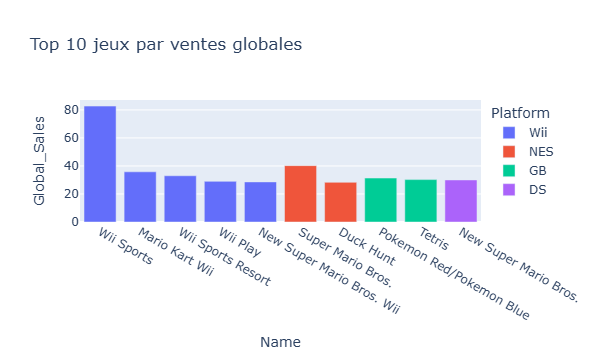

In [50]:
#Analyse exploration
#Top 10 des jeux par ventes globales
top_games = df.nlargest(10, 'Global_Sales')[['Name', 'Platform', 'Year', 'Global_Sales']]
px.bar(top_games, x='Name', y='Global_Sales', color='Platform',
       title="Top 10 jeux par ventes globales").show()


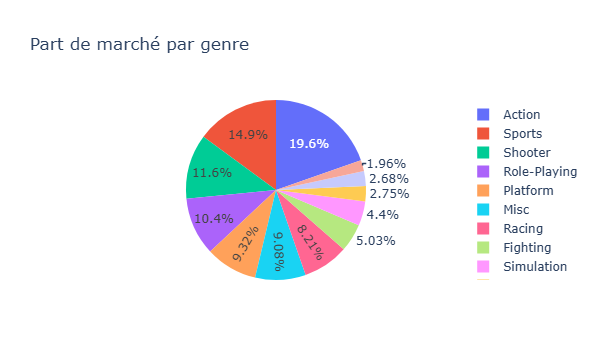

In [51]:
#Répartition par genre
px.pie(df, names='Genre', values='Global_Sales',
       title='Part de marché par genre').show()


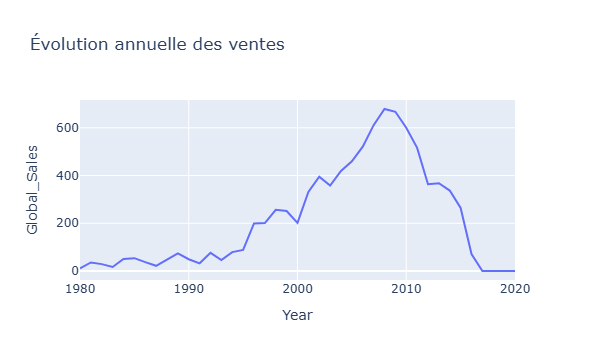

In [52]:
#Evolution annuelle des ventes
sales_year = df.groupby('Year', as_index=False)['Global_Sales'].sum()
px.line(sales_year, x='Year', y='Global_Sales',
        title="Évolution annuelle des ventes").show()


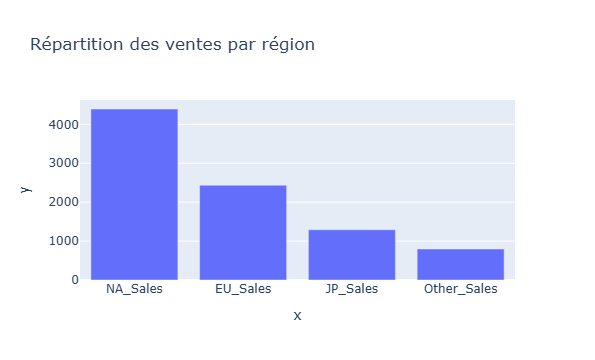

In [53]:
#Analyses régionales
regional_sales = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
px.bar(x=regional_sales.index, y=regional_sales.values,
       title="Répartition des ventes par région").show()


In [60]:
#Construction d'un modèle qui prédit les ventes globales d'un jeu vidéo à partir
#de ses caractéristiques connues

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Définition des caractéristiques (x) et de la cible (y) 
X = df[['Platform', 'Year', 'Genre', 'Publisher']].copy()
y = df['Global_Sales'].copy()

# Convertion de Year
X['Year'] = pd.to_numeric(X['Year'], errors='coerce').astype(float)

# Réduire Publisher à 30 pour éviter un encoade avec trop de colonnes
top_publishers = X['Publisher'].value_counts().nlargest(30).index
X['Publisher'] = X['Publisher'].where(X['Publisher'].isin(top_publishers), other='Other')

#Définition des colonnes numériques et catégorielles
numeric_features = ['Year']
categorical_features = ['Platform', 'Genre', 'Publisher']

#OneHotEncoder : transformation de chaque colonne en plusieurs colonnes binaires (0 ou 1)
try:
    # sklearn >= 1.2
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    # versions antérieures
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#Pipelines de prétraitement (préparation des colonnes numériques et catégorilles)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), #remplace valeurs manquantes par médiane
    ('scaler', StandardScaler()) #toutes les colonnnes sur la même échelle
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', ohe)
])

#Combination des deux transformations
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#RandomForestRegressor (pour données tabulaires, robuste aux outliers)
reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model = Pipeline([
    ('pre', preprocessor),
    ('reg', TransformedTargetRegressor(regressor=reg, func=np.log1p, inverse_func=np.expm1))
])

# Split train/test (80% entraînement, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
#Prédictions
y_pred = model.predict(X_test)

#Evaluation du modèle (Root Mean Squared Error / coefficient de détermination)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

#Importance des variables 
#Mélange des valeurs d'une colonne pour voir combien les prédictions se dégradent
#Plus la dégradation est grande, plus la variable est importante
perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Reconstruction des noms de features après preprocessing 
# On récupère l'OHE effectivement utilisé dans le pipeline entrainé
fitted_ohe = model.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
try:
    cat_cols = fitted_ohe.get_feature_names_out(categorical_features)
except AttributeError:
    # fallback pour anciennes versions
    try:
        cat_cols = fitted_ohe.get_feature_names(categorical_features)
    except Exception:
        # dernier fallback : créer des noms génériques
        transformed_sample = fitted_ohe.transform(X_test[categorical_features].iloc[:1])
        n_cat = transformed_sample.shape[1]
        cat_cols = [f"cat_{i}" for i in range(n_cat)]

feature_names = numeric_features + list(cat_cols)

# Vérification de la dimension et afficher top importances
if len(feature_names) == perm.importances_mean.shape[0]:
    importances = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)
else:
    # si mismatch, afficher importances sans labels
    importances = pd.Series(perm.importances_mean).sort_values(ascending=False)

print("\nTop features (permutation importance) :")
print(importances.head(20))


RMSE : 1.9984
R²   : 0.0495

Top features (permutation importance) :
3    0.099762
0    0.026368
2    0.022110
1    0.016485
dtype: float64


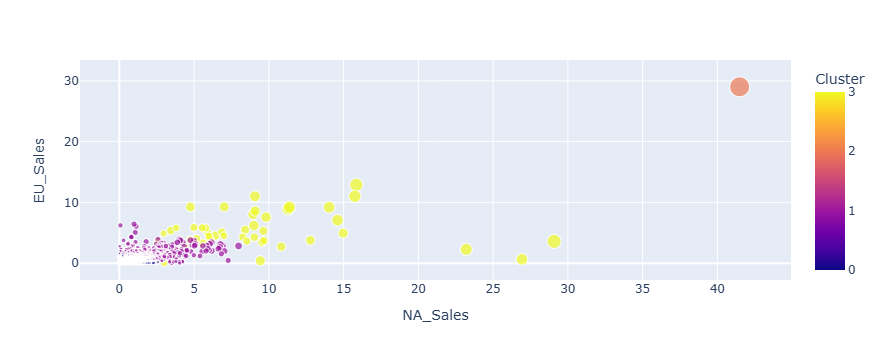

In [57]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#On garde seulement les colonnes de ventes (remplissage des NaN par 0)
cluster_data = df[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].fillna(0)
cluster_scaled = StandardScaler().fit_transform(cluster_data)

#Application de K-Means (avec n_clusters=4 comme exemple)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(cluster_scaled) #Mise à l'échelle (important pour le clustering

#Visualisation des clusters
px.scatter(df, x='NA_Sales', y='EU_Sales', color='Cluster',
           size='Global_Sales', hover_data=['Name']).show()
#Interprétation : la grande majorité des jeux (nuage violet en bas à gauche) se vendent peu partout.
#un groupe groupe sort du lot avec des ventes régionales solides
#un point isolés (Wii Sports) explosent tous les records


In [ ]:
Résumé
Jeux les plus vendues : Wii Sports, Mario Kart Wii

Genres les plus performants : Action, Sports

Évolution dans le temps : pic en 2008, tendance acteulle stagnante (avec forte
chute de 2008 à 2017

Région la plus rentable : Amérique du Nord

Clusters identifiés :

Publisher = 0.0998( l'éditeur est le plus impactant )

Year = 0.0264

Genre = 0.0221

Platform = 0.0165


Modèle prédictif : R² = 0.0495, RMSE = 1.9984 → interprétation : Le RMSE montre
qu'il y a environ 2 millions d'écart moyen entre la valeur réelle et la valeur 
prédite. Même si le coefficient de détermination est supérieur à 0, il reste très faible ce qui montre
que les variables disponibles ne suffisent pas à expliquer les ventes.

Insights business :

Investir davantage sur les franchises qui apparaissent dans les clusters 1 et 3, car
ils concentrent des ventes élevées.Les hits simultanément fort en Amérique et Europe
semblent être plus rentables

Surveiller le marché japonais car il présente un profil de ventes très différent,
avec certains genres (RPG, Visual Novels) qui peuvent cartonner localement mais 
pas ailleurs. Une évolution dans les goûts ou un succès inattendu pourrait 
être une opportunité ou un risque.
    
Potentiel de croissance sur les marchés "Other" (reste du monde) et Europe, où 
certains genres ou franchises pourraient croître davantage si localisés 
correctement (traduction, adaptation culturelle) et soutenus par du marketing ciblé.

